In [2]:
import data_loader_utility as dlu
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_dl, test_dl, val_dl = dlu.get_dataloaders()
X_train, X_test, y_train, y_test = dlu.get_tabular_data()

In [4]:
# import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

class HomemadeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1)  # review wht the different channels are (andrew ng)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(28, 14, kernel_size=3, stride=1, padding=1)  # default padding is 0, so we need to specify 1 to get the dimensions we want
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # new convolutionl layer
        # self.conv3 = nn.Conv2d(14, 7, kernel_size=3, stride=1, padding=1)
        # self.act3 = nn.ReLU()
        # self.pool3 = nn.MaxPool2d(kernel_size=2)

        # batchnorm dded
        # self.bn1 = nn.BatchNorm2d()  # how does this value affect the later layers, accuracy, etc.?

        self.flat = nn.Flatten()
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x3388 and 343x343)
        self.fc4 = nn.Linear(14*7*7, 343)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(343, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        # print(x.shape, 'original')
        x = self.act1(self.conv1(x))
        # print(x.shape, 'after first conv and before 1st maxpool')
        x = self.pool1(x)
        # print(x.shape, 'after 1st maxpool')
        # x = self.drop1(x)
        # print(x.shape, 'after dropout')
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # print(x.shape, 'after 2nd conv')
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # print(x.shape, 'after 2nd maxpool')
        # new conv layer
        # x = self.act3(self.conv3(x))
        # print(x.shape, 'after 3rd conv')
        # x = self.pool3(x)
        # print(x.shape, 'after 2nd pool')
        # input 32x16x16, output 8192
        x = self.flat(x)
        # print(x.shape, 'after flattening')
        # input 8192, output 512
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        # print(x.shape, 'after last dropout layer')
        # input 512, output 10
        x = self.fc5(x)
        # print(x.shape, 'last shape after nn.Linear(343, 10)\n\n')
        return x


In [5]:
trained = HomemadeCNN()
trained.load_state_dict(torch.load('homemademodel.pth'))
trained.eval()

HomemadeCNN(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=686, out_features=343, bias=True)
  (act4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=343, out_features=10, bias=True)
)

In [6]:
trained.fc5 = nn.Sequential()  # choose a given layer to change to nn.Sequential() and set all subsequent layers to this to get the output from it
trained

HomemadeCNN(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc4): Linear(in_features=686, out_features=343, bias=True)
  (act4): ReLU()
  (drop4): Dropout(p=0.2, inplace=False)
  (fc5): Sequential()
)

In [7]:
# load an image to play around with
imgs, labels = next(iter(train_dl))
# plt.imshow(imgs[1].reshape(28,28), cmap='gray')
feat_map_gen_img = imgs[1] #.reshape(28,28)
feat_map_gen_img = feat_map_gen_img.to(device)

trained(imgs).shape

torch.Size([32, 343])

In [65]:
index = 0
new_features = np.zeros((50000, 343))
new_targets = np.zeros(50000)
# new_features = np.zeros((343, 1))

for inputs, labels in train_dl:
    labels = labels.to(device)
    # print(labels)
    inputs = inputs.to(device)
    outputs = trained(inputs)
    for row in outputs:
        new_features[index, :] = row.detach().numpy()
        index += 1


# gets all the labels from the dataloader
other_index = 0
for inputs, labels in train_dl:
    labels = labels.to(device)
    for lab in labels:
        # print(lab)
        new_targets[other_index] = float(lab)
        other_index += 1
        # print(lab)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn.utils._param_validation import InvalidParameterError
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def random_forest(xtrain, xtest, ytrain, ytest, grid_to_search={}):
    """Fit a random forest classifier and display performance metrics (acc/prec/rec/f1) and confusion matrix."""
    np.random.seed(64)

    rfc = RandomForestClassifier()
    try:
        optimal = GridSearchCV(rfc, grid_to_search, refit=True)
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)
    except InvalidParameterError as e:
        print(f'{e}\nAttempting to fit with a default Random Forest classifier.')
        optimal = RandomForestClassifier()
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)

    # optimal.fit(xtrain, ytrain)
    # internal_preds = optimal.predict(xtest)

    # check performance
    print('MODEL PERFORMANCE:\n-------------\naccuracy: ', metrics.accuracy_score(ytest, internal_preds),
          '\nprecision: ', metrics.precision_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'),
          '\nrecall: ', metrics.recall_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'),
          '\nf1-score: ', metrics.f1_score(ytest, internal_preds, labels=[int(x) for x in list(set(ytrain))], average='macro'))
    confmat_internal = metrics.confusion_matrix(ytest, internal_preds)
    show_confmat_internal = metrics.ConfusionMatrixDisplay(confmat_internal)
    show_confmat_internal.plot()
    plt.show()


def k_nearest_neighbors(xtrain, xtest, ytrain, ytest, grid_to_search={}):
    """Fit a KNN classifier and display performance metrics (acc/prec/rec/f1) and confusion matrix"""
    np.random.seed(64)

    knn = KNeighborsClassifier()
    try:
        optimal = GridSearchCV(knn, grid_to_search, refit=True)
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)
    except InvalidParameterError as e:
        print(f'{e}\nAttempting to fit with a default KNN classifier.')
        optimal = KNeighborsClassifier()
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)

    # optimal.fit(xtrain, ytrain)
    # internal_preds = optimal.predict(xtest)

    # check performance
    print('MODEL PERFORMANCE:\n-------------\naccuracy: ', metrics.accuracy_score(ytest, internal_preds),
          '\nprecision: ', metrics.precision_score(ytest, internal_preds, labels=[int(x) for x in list(set(y_train_s))], average='macro'),
          '\nrecall: ', metrics.recall_score(ytest, internal_preds, labels=[int(x) for x in list(set(y_train_s))], average='macro'),
          '\nf1-score: ', metrics.f1_score(ytest, internal_preds, labels=[int(x) for x in list(set(y_train_s))], average='macro'))
    confmat_internal = metrics.confusion_matrix(ytest, internal_preds)
    show_confmat_internal = metrics.ConfusionMatrixDisplay(confmat_internal)
    show_confmat_internal.plot()
    plt.show()


def support_vector_machine(xtrain, xtest, ytrain, ytest, grid_to_search={}):
    """Fit a support vector machine classifier and display performance metrics (acc/prec/rec/f1) and confusion matrix"""
    np.random.seed(64)

    svm = SVC()
    try:
        optimal = GridSearchCV(svm, grid_to_search, refit=True)
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)
    except InvalidParameterError as e:
        print(f'{e}\nAttempting to fit with a default SVM classifier.')
        optimal = SVC()
        optimal.fit(xtrain, ytrain)
        internal_preds = optimal.predict(xtest)
    
    # optimal.fit(xtrain, ytrain)
    # internal_preds = optimal.predict(xtest)

    # check performance
    print('MODEL PERFORMANCE:\n-------------\naccuracy: ', metrics.accuracy_score(ytest, internal_preds),
          '\nprecision: ', metrics.precision_score(ytest, internal_preds, labels=[int(x) for x in list(set(y_train_s))], average='macro'),
          '\nrecall: ', metrics.recall_score(ytest, internal_preds, labels=[int(x) for x in list(set(y_train_s))], average='macro'),
          '\nf1-score: ', metrics.f1_score(ytest, internal_preds, labels=[int(x) for x in list(set(y_train_s))], average='macro'))
    confmat_internal = metrics.confusion_matrix(ytest, internal_preds)
    show_confmat_internal = metrics.ConfusionMatrixDisplay(confmat_internal)
    show_confmat_internal.plot()
    plt.show()


def lda(features, targets, n_components):
    """Separately fit LDA to train and test sets and return train/test features and targets like sklearn.train_test_split."""
    np.random.seed(64)
    X_train_, X_test_, y_train_, y_test_ = train_test_split(features, targets,
                                                            test_size=.25, random_state=64)

    # transform train data
    lda_train = LinearDiscriminantAnalysis(n_components=n_components)
    new_train_features = lda_train.fit_transform(X_train_, y_train_.reshape(-1, 1))
    new_train_targets = lda_train.transform(X_test_)

    # transform test data
    lda_test = LinearDiscriminantAnalysis(n_components=n_components)
    new_test_features = lda_test.fit_transform(X_test_, y_test_.reshape(-1, 1))
    new_test_targets = lda_test.transform(X_test_)

    return new_train_features, new_test_features, new_train_targets, new_test_targets


X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(new_features, new_targets,
                                                            test_size=.25, random_state=64)

MODEL PERFORMANCE:
-------------
accuracy:  0.9159468969929623 
precision:  0.9161426137586824 
recall:  0.9164444747573451 
f1-score:  0.9161960289287621


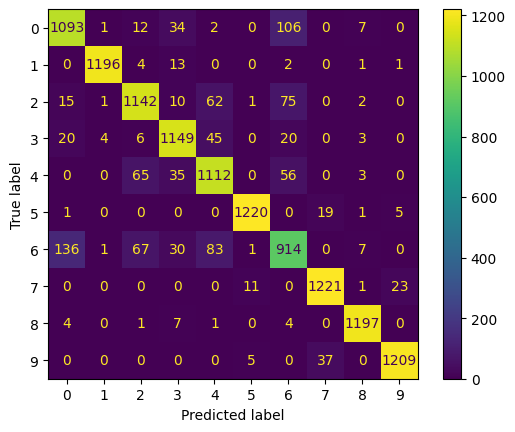

In [36]:
random_forest(X_train_s, X_test_s, y_train_s, y_test_s, {})

MODEL PERFORMANCE:
-------------
accuracy:  0.9102687140115163 
precision:  0.9109059042498991 
recall:  0.910855018316768 
f1-score:  0.910835919681776


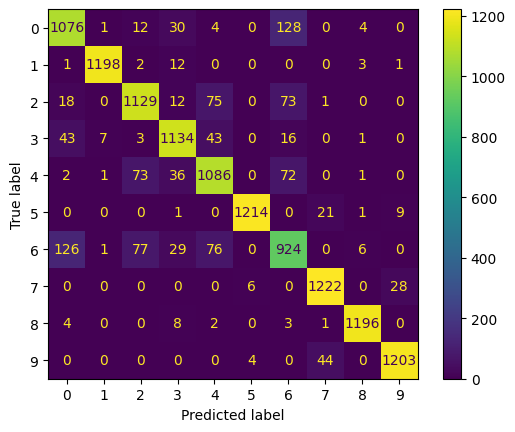

In [56]:
k_nearest_neighbors(X_train_s, X_test_s, y_train_s, y_test_s)

MODEL PERFORMANCE:
-------------
accuracy:  0.9301823416506718 
precision:  0.9307683982089218 
recall:  0.930666213151366 
f1-score:  0.9306565837909773


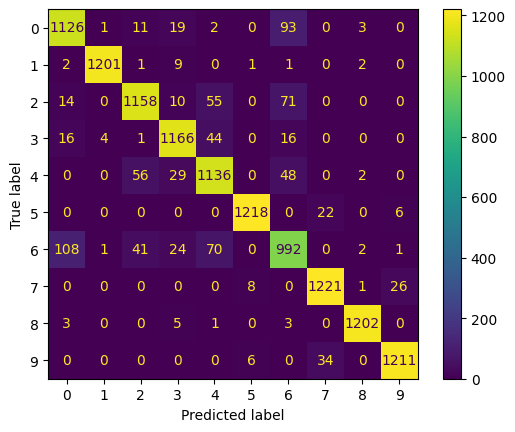

In [57]:
support_vector_machine(X_train_s, X_test_s, y_train_s, y_test_s)

c:\Users\jackw\gradschool\.venv\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
